In [13]:

import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt


In [91]:

# !ffmpeg -i clip.mp4 -vf fps=1  2_lane_frames/frame_%d.png

In [175]:
#front to top view

# concept????


#     Attributes:
#         src (np.array): Coordinates of 4 source points
#         dst (np.array): Coordinates of 4 destination points
#         M (np.array): Matrix to transform image from front view to top view
#         M_inv (np.array): Matrix to transform image from top view to front view
src = np.float32([(650, 750),     # top-left
                   (100, 1080),     # bottom-left
                   (1650, 1080),    # bottom-right
                   (1300, 750)])    # top-right
dst = np.float32([(100, 0),
                       (100, 1080),
                       (1600, 1080),
                       (1600, 0)])

def tr_top_view(img, img_size, flags=cv2.INTER_LINEAR):


    M = cv2.getPerspectiveTransform(src, dst)
    
    return cv2.warpPerspective(img, M, img_size, flags=flags)




def tr_back_view(img, img_size, flags=cv2.INTER_LINEAR):

        
        M_inv = cv2.getPerspectiveTransform(dst, src)


        return cv2.warpPerspective(img, M_inv, img_size, flags=flags)



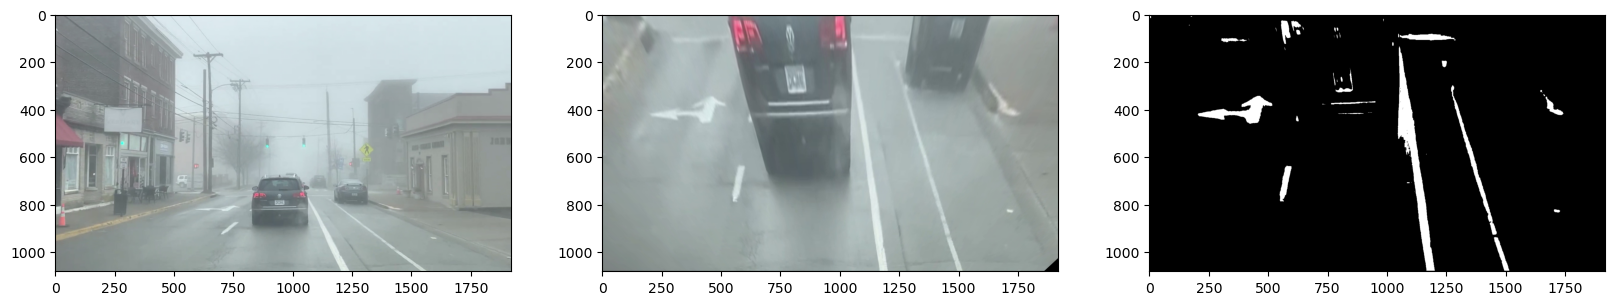

In [176]:
img = cv2.imread('2_lane_frames/frame_60.png')
top_view=tr_top_view(img, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
a,b,lane_filtered=filter_lane(top_view)
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(top_view, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(lane_filtered, cv2.COLOR_BGR2RGB))

plt.show()



In [168]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255


def filter_lane(img):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]

#     return h_channel,l_channel,s_channel,v_channel
    right_lane = threshold_rel(l_channel, 0.8, 1.0)
    right_lane[:,:800] = 0

#     left_lane = threshold_abs(h_channel, 20, 30)
    left_lane = threshold_rel(v_channel, 0.8, 1.0)
    left_lane[:,800:] = 0

    img2 = left_lane | right_lane

    return left_lane,right_lane,img2

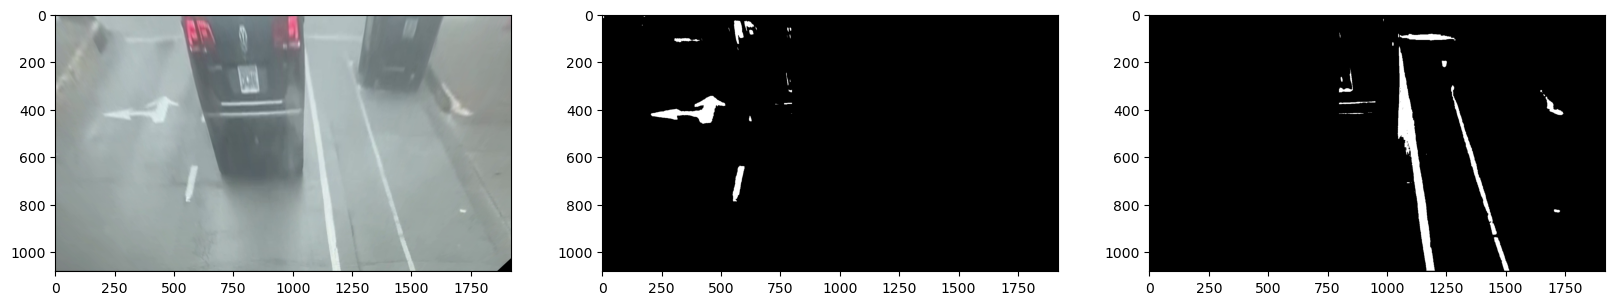

In [177]:
img = cv2.imread('2_lane_frames/frame_60.png')
top_view=tr_top_view(img, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
a,b,lane_filtered=filter_lane(top_view)
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(top_view, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(b, cv2.COLOR_BGR2RGB))
# ax[2].imshow(cv2.cvtColor(lane_filtered, cv2.COLOR_BGR2RGB))
# ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

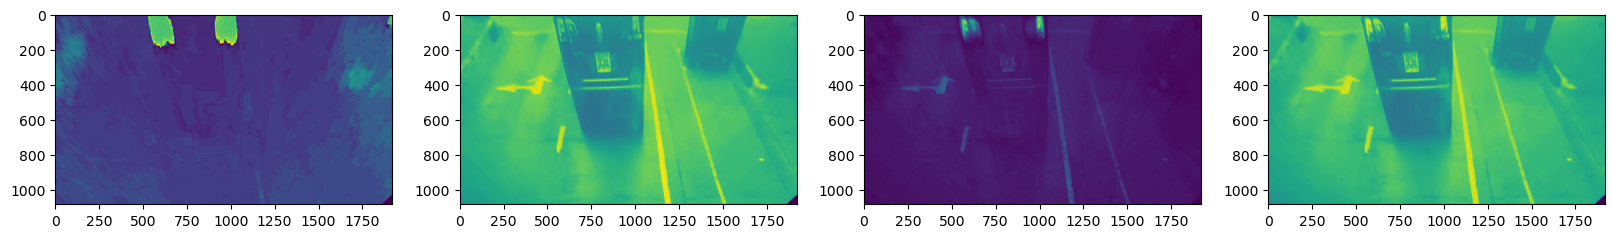

In [163]:
img = cv2.imread('2_lane_frames/frame_60.png')
top_view=tr_top_view(img, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
h,l,s,v=filter_lane(top_view)
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(h)
ax[1].imshow(l)
ax[2].imshow(s)
ax[3].imshow(v)

plt.show()

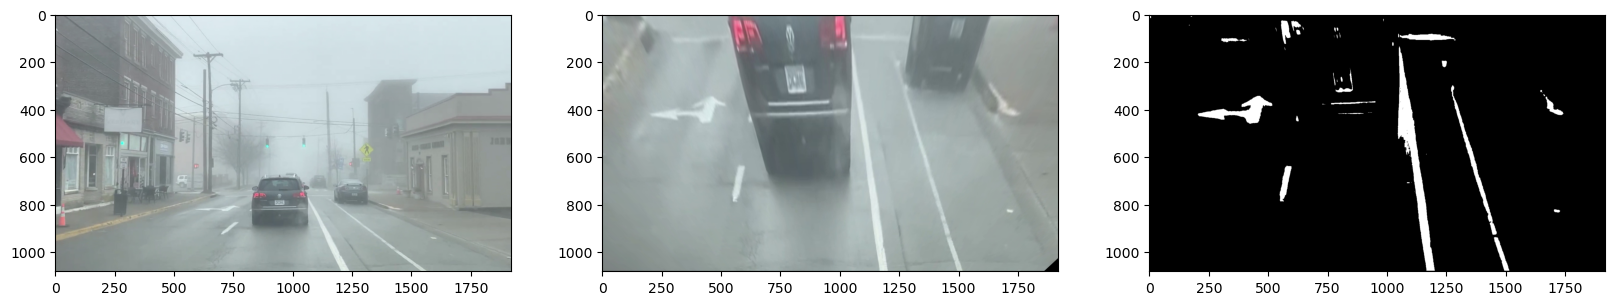

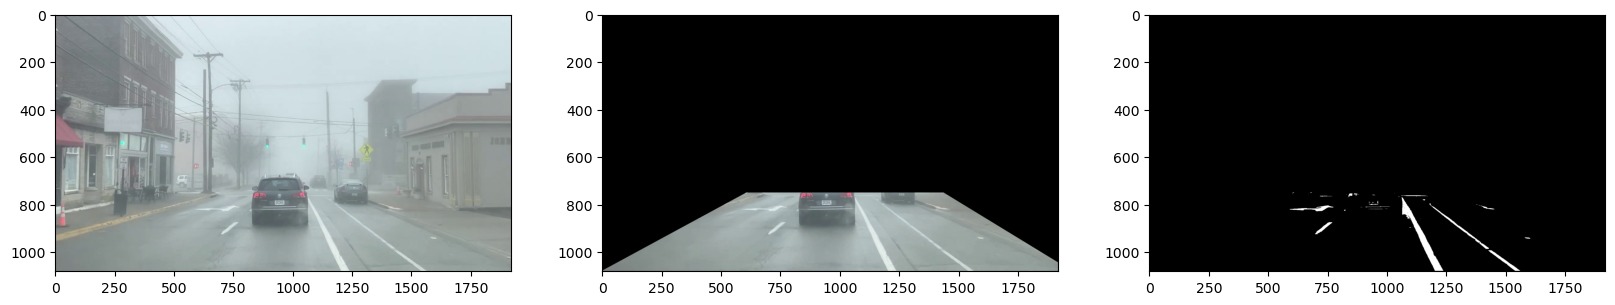

In [178]:
img = cv2.imread('2_lane_frames/frame_60.png')
top_view=tr_top_view(img, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
a,b,lane_filtered=filter_lane(top_view)
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(top_view, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(lane_filtered, cv2.COLOR_BGR2RGB))

plt.show()

back_view1=tr_back_view(top_view, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

back_view=tr_back_view(lane_filtered, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(back_view1, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(back_view, cv2.COLOR_BGR2RGB))

plt.show()

In [179]:
def extract_features(img , nwindows = 9):
#     """ Extract features from a binary image

#     Parameters:
#         img (np.array): A binary image
#     """
    # Number of sliding windows
    
    # Height of of windows - based on nwindows and image shape
    window_height = np.int(img.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixel in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    return window_height , nwindows ,nonzero , nonzerox ,nonzeroy

In [180]:
def pixels_in_window(center, margin, height):
    
#     """ Return all pixel that in a specific window

#     Parameters:
#         center (tuple): coordinate of the center of the window
#         margin (int): half width of the window
#         height (int): height of the window

#     Returns:
#         pixelx (np.array): x coordinates of pixels that lie inside the window
#         pixely (np.array): y coordinates of pixels that lie inside the window
#     """

    topleft = (center[0]-margin, center[1]-height//2)
    bottomright = (center[0]+margin, center[1]+height//2)

    condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
    condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
    
    return nonzerox[condx&condy], nonzeroy[condx&condy]


In [181]:
margin = 100
# Mininum number of pixels found to recenter window
minpix = 50

def find_lane_pixels(img):
#     """Find lane pixels from a binary warped image.

#     Parameters:
#         img (np.array): A binary warped image

#     Returns:
#         leftx (np.array): x coordinates of left lane pixels
#         lefty (np.array): y coordinates of left lane pixels
#         rightx (np.array): x coordinates of right lane pixels
#         righty (np.array): y coordinates of right lane pixels
#         out_img (np.array): A RGB image that use to display result later on.
#     """
    assert(len(img.shape) == 2)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))

    
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Current position to be update later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    y_current = img.shape[0] + window_height//2

    # Create empty lists to reveice left and right lane pixel
    leftx, lefty, rightx, righty = [], [], [], []

    # Step through the windows one by one
    for _ in range(nwindows):
        y_current -= window_height
        center_left = (leftx_current, y_current)
        center_right = (rightx_current, y_current)

        good_left_x, good_left_y = pixels_in_window(center_left, margin, window_height)
        good_right_x, good_right_y = pixels_in_window(center_right, margin, window_height)

        # Append these indices to the lists
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)
        rightx.extend(good_right_x)
        righty.extend(good_right_y)

        if len(good_left_x) > minpix:
            leftx_current = np.int32(np.mean(good_left_x))
        if len(good_right_x) > minpix:
            rightx_current = np.int32(np.mean(good_right_x))

    return leftx, lefty, rightx, righty, out_img

In [182]:
def measure_curvature(left_fit,right_fit):
    ym = 30/720
    xm = 3.7/700

    left_fit = left_fit.copy()
    right_fit = right_fit.copy()
    y_eval = 700 * ym

    # Compute R_curve (radius of curvature)
    left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
    right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    xl = np.dot(left_fit, [700**2, 700, 1])
    xr = np.dot(right_fit, [700**2, 700, 1])
    pos = (1280//2 - (xl+xr)//2)*xm
    return left_curveR, right_curveR, pos 

In [183]:
left_fit = None
right_fit = None
def fit_poly(img):
#     """Find the lane line from an image and draw it.

#     Parameters:
#         img (np.array): a binary warped image

#     Returns:
#         out_img (np.array): a RGB image that have lane line drawn on that.
#     """

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

#     print(len(lefty))
    
    if len(lefty) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    maxy = img.shape[0] - 1
    miny = img.shape[0] // 3
    
    if len(lefty):
        maxy = max(maxy, np.max(lefty))
        miny = min(miny, np.min(lefty))

    if len(righty):
        maxy = max(maxy, np.max(righty))
        miny = min(miny, np.min(righty))

    ploty = np.linspace(miny, maxy, img.shape[0])

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Visualization
        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

        lR, rR, pos = measure_curvature(left_fit,right_fit)

    except:
        pass
    return out_img

C:\Users\ghand\AppData\Local\Temp\ipykernel_11256\3050424909.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_height = np.int(img.shape[0]//nwindows)


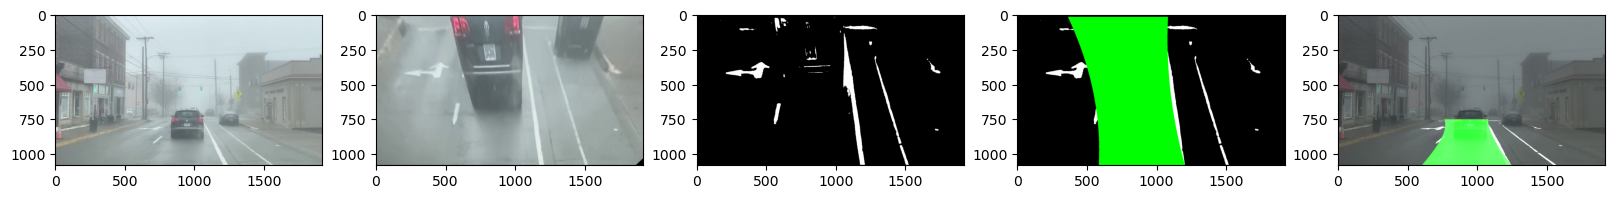

In [184]:
img = cv2.imread('2_lane_frames/frame_60.png')
top_view=tr_top_view(img, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
a,b,lane_filtered=filter_lane(top_view)
window_height , nwindows ,nonzero , nonzerox ,nonzeroy = extract_features(lane_filtered , nwindows = 9)
ployy=fit_poly(lane_filtered)
back_view=tr_back_view(ployy, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
out_img = cv2.addWeighted(back_view, 1, img, 0.6, 0)

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(top_view, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(lane_filtered, cv2.COLOR_BGR2RGB))
ax[3].imshow(cv2.cvtColor(ployy, cv2.COLOR_BGR2RGB))
ax[4].imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

plt.show()

In [187]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
# Define the input and output folder paths
in_folder_path = "2_lane_frames"
out_folder_path = "2_lane_frames_out"
i=0


def last_4chars(x):
    return(int(x[6:-4]))

for file_name in tqdm(sorted(os.listdir(in_folder_path), key = last_4chars)):

    i+=1
    if file_name.endswith(f"{i}.png"):
        # Construct the full file path
        file_path = os.path.join(in_folder_path, file_name)
        
        img = cv2.imread(file_path)
        top_view=tr_top_view(img, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
        a,b,lane_filtered=filter_lane(top_view)
        ployy=fit_poly(lane_filtered)
        back_view=tr_back_view(ployy, img_size=(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
        out_img = cv2.addWeighted(back_view, 1, img, 0.6, 0)

        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(top_view, cv2.COLOR_BGR2RGB))
        ax[2].imshow(cv2.cvtColor(lane_filtered, cv2.COLOR_BGR2RGB))
        ax[3].imshow(cv2.cvtColor(ployy, cv2.COLOR_BGR2RGB))
        ax[4].imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

        output_path = os.path.join(out_folder_path, file_name)
#         ax.axis('off')
        plt.savefig(output_path)
        plt.close()
        

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [01:34<00:00,  1.24s/it]


In [ ]:
#     def plot(self, out_img):
#         np.set_printoptions(precision=6, suppress=True)
#         lR, rR, pos = self.measure_curvature()

#         value = None
#         if abs(self.left_fit[0]) > abs(self.right_fit[0]):
#             value = self.left_fit[0]
#         else:
#             value = self.right_fit[0]

#         if abs(value) <= 0.00015:
#             self.dir.append('F')
#         elif value < 0:
#             self.dir.append('L')
#         else:
#             self.dir.append('R')
        
#         if len(self.dir) > 10:
#             self.dir.pop(0)

#         W = 400
#         H = 500
#         widget = np.copy(out_img[:H, :W])
#         widget //= 2
#         widget[0,:] = [0, 0, 255]
#         widget[-1,:] = [0, 0, 255]
#         widget[:,0] = [0, 0, 255]
#         widget[:,-1] = [0, 0, 255]
#         out_img[:H, :W] = widget

#         direction = max(set(self.dir), key = self.dir.count)
#         msg = "Keep Straight Ahead"
#         curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
#         if direction == 'L':
#             y, x = self.left_curve_img[:,:,3].nonzero()
#             out_img[y, x-100+W//2] = self.left_curve_img[y, x, :3]
#             msg = "Left Curve Ahead"
#         if direction == 'R':
#             y, x = self.right_curve_img[:,:,3].nonzero()
#             out_img[y, x-100+W//2] = self.right_curve_img[y, x, :3]
#             msg = "Right Curve Ahead"
#         if direction == 'F':
#             y, x = self.keep_straight_img[:,:,3].nonzero()
#             out_img[y, x-100+W//2] = self.keep_straight_img[y, x, :3]

#         cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
#         if direction in 'LR':
#             cv2.putText(out_img, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

#         cv2.putText(
#             out_img,
#             "Good Lane Keeping",
#             org=(10, 400),
#             fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#             fontScale=1.2,
#             color=(0, 255, 0),
#             thickness=2)

#         cv2.putText(
#             out_img,
#             "Vehicle is {:.2f} m away from center".format(pos),
#             org=(10, 450),
#             fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#             fontScale=0.66,
#             color=(255, 255, 255),
#             thickness=2)

#         return out_img

In [ ]:
out_img = self.lanelines.plot(out_img)